# Navier-Stokes in Julia

## Homebrew matrix operation debugger

In [55]:
function init_traverse(ex::Expr)
    (exp_stack,symbol_size) = traverse(ex);
    try 
        error_loc = pop!(exp_stack);  
        return (error_loc,symbol_size)
    catch e
        println("Dimensions are correct, no errors raised 👍")
        return (undef,undef)
    end
    
    
end

function traverse(ex::Expr)
    exp_stack = [];
    symbol_size = Dict();
    traverse(ex,exp_stack,symbol_size)
end

function traverse(ex::Symbol,exp_stack,symbol_size)
    try symbol_size[string(ex)] = size(eval(ex))
        catch e  #not the nicest code  
    end
end

function traverse(ex::Expr,exp_stack,symbol_size) 
    if ex.head == :call  # function call 
        arg = ex.args[1];
        if (string(arg) != ":")
            test!(arg,exp_stack,symbol_size)
        end
        # Here all the operators are skipped because they are the first argument
        for arg in ex.args[2:end]
            if (string(arg) != ":")
                test!(arg,exp_stack,symbol_size)
            end
            traverse(arg,exp_stack,symbol_size);  # recursive
        end
    
        elseif ex.head == :ref # now where at the indexing level and stop here
        symbol_size[string(ex)] = size(eval(ex));
        a = size(eval(ex));
        
    else
        for arg in ex.args
            test!(arg,exp_stack,symbol_size)
            traverse(arg,exp_stack,symbol_size);  # recursive
        end
    end
    
    return (exp_stack,symbol_size)
end

function traverse(ex,exp_stack,symbol_size)
end

function test!(ex::Expr,exp_stack,symbol_size)
    try 
        eval(ex);
    catch e
        push!(exp_stack,ex); 
    end
end

function test!(ex,exp_stack,symbol_size)
    # If not an expression just ignore
end

function expr_to_size_string(ex::UndefInitializer,symbol_size::UndefInitializer)
    #Do nothing
end

function expr_to_size_string(ex::Expr,symbol_size::Dict)
    str = string(ex);
    size_str = str
    for (key, value) in symbol_size
        size_str = replace(size_str, string(key) => string(value))
    end
    return "Error in expression '" * str * "' with dimensions '" * size_str *"'"
end

macro dimensionCheck(ex)
    (exp_stack,symbol_size) = init_traverse(esc(ex))
    return expr_to_size_string(exp_stack,symbol_size)
end

@dimensionCheck (macro with 1 method)

## Step 12: Channel Flow with Navier–Stokes
----


The only difference between this final step and Step 11 is that we are going to add a source term to the $u$-momentum equation, to mimic the effect of a pressure-driven channel flow. Here are our modified Navier–Stokes equations:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right)+F$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)$$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}=-\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
$$

### Discretized equations (explicit)

With patience and care, we write the discretized form of the equations. It is highly recommended that you write these in your own hand, mentally following each term as you write it.

The $u$-momentum equation:

$$
\begin{split}
& \frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y} = \\
& \qquad -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x} \\
& \qquad +\nu\left(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2}\right)+F_{i,j}
\end{split}
$$

The $v$-momentum equation:

$$
\begin{split}
& \frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y} = \\
& \qquad -\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y} \\
& \qquad +\nu\left(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2}\right)
\end{split}
$$

And the pressure equation:

$$
\begin{split}
& \frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2} + \frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2} = \\
& \qquad \rho\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right) - \frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} - 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} - \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

The initial condition is $u, v, p=0$ everywhere, and at the boundary conditions are:

$u, v, p$ are periodic on $x=0,2$

$u, v =0$ at $y =0,2$

$\frac{\partial p}{\partial y}=0$ at $y =0,2$

$F=1$ everywhere.

The pressure Poisson equation that's written above can be hard to write out without typos. The function build_up_b below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.

In [200]:
"""Constructs the pressure-Poisson equation"""
function build_up_b(ρ,Δt,Δx,Δy,u,v)
    b = similar(u)
    b[2:end-1, 2:end-1] = @. (ρ * (1 / Δt * ((u[2:end-1, 3:end] - u[2:end-1, 1:end-2]) / (2 * Δx) +
            (v[3:end, 2:end-1] - v[1:end-2, 2:end-1]) / (2 * Δy)) -
        ((u[2:end-1, 3:end] - u[2:end-1, 1:end-2]) / (2 * Δx))^2 -
        2 * ((u[3:end, 2:end-1] - u[1:end-2, 2:end-1]) / (2 * Δy) *
            (v[2:end-1, 3:end] - v[2:end-1, 1:end-2]) / (2 * Δx))-
        ((v[3:end, 2:end-1] - v[1:end-2, 2:end-1]) / (2 * Δy))^2))
end

"""Updates the periodic boundary conditions of the pressure Poisson equation"""
function update_periodic_bc_b!(b,ρ,Δt,Δx,Δy,u,v)
    # Periodic BC Pressure @ x = 2
    b[2:end-1, end] = @. (ρ * (1 / Δt * ((u[2:end-1, 1] - u[2:end-1,end-1]) / (2 * Δx) +
                (v[3:end, end] - v[1:end-2, end]) / (2 * Δy)) -
            ((u[2:end-1, 1] - u[2:end-1, end-1]) / (2 * Δx)).^2 -
            2 * ((u[3:end, end] - u[1:end-2, end]) / (2 * Δy) .*
                (v[2:end-1, 1] - v[2:end-1, end-1]) / (2 * Δx)) -
            ((v[3:end, end] - v[1:end-2, end]) / (2 * Δy)).^2))

    # Periodic BC Pressure @ x = 0
b[2:end-1, 1] = @. (ρ * (1 / Δt * ((u[2:end-1, 1] - u[2:end-1, end]) / (2 * Δx) +
                (v[3:end, 1] - v[1:end-2, 1]) / (2 * Δy)) -
        ((u[2:end-1, 1] - u[2:end-1, end]) / (2 * Δx)).^2 -
        2 * ((u[3:end, 1] - u[1:end-2, 1]) / (2 * Δy) .*
                (v[2:end-1, 1] - v[2:end-1, end]) / (2 * Δx))-
        ((v[3:end, 1] - v[1:end-2, 1]) / (2 * Δy)).^2))
end

"""Solves the pressure Poisson equation with periodic boundary conditions"""
function solve_pressure_poisson_periodic!(p,Δx,Δy,num_it)
    for q in 1:num_it
        pn = p[:,:]
        
        p[2:end-1, 2:end-1] = @. (((pn[2:end-1, 3:end] + pn[2:end-1, 1:end-2]) * Δy^2 + (pn[3:end, 2:end-1] +
                    pn[1:end-2, 2:end-1]) * Δx^2) / (2 * (Δx^2 + Δy^2)) - Δx^2 * Δy^2 / (2 * (Δx^2 + Δy^2)) * 
                    b[2:end-1, 2:end-1])

        # Periodic BC Pressure @ x = 2
        p[2:end-1, end] = @. (((pn[2:end-1, 1] + pn[2:end-1, end-1])* Δy^2 +
                        (pn[3:end, end] + pn[1:end-2, end]) * Δx^2) /
                               (2 * (Δx^2 + Δy^2)) -
                    Δx^2 * Δy^2 / (2 * (Δx^2 + Δy^2)) * b[2:end-1, end])

        # Periodic BC Pressure @ x = 0
        p[2:end-1, 1] = @. (((pn[2:end-1, 1] + pn[2:end-1, end])* Δy^2 +
                (pn[3:end, 1] + pn[1:end-2, 1]) * Δx^2) /
                              (2 * (Δx^2 + Δy^2)) -
            Δx^2 * Δy^2 / (2 * (Δx^2 + Δy^2)) * b[2:end-1, 1])

        # Wall boundary conditions, pressure
        p[end, :] =p[end-1, :]  # dp/dy = 0 at y = 2
        p[1, :] = p[2, :]  # dp/dy = 0 at y = 0   
        println(mean(p))
    end
end

function momentum_periodic!(u,v,Δx,Δy,ρ,ν,F)
    
    u[2:end-1, 2:end-1] = @. (un[2:end-1, 2:end-1] -
                         un[2:end-1, 2:end-1] * Δt / Δx * 
                        (un[2:end-1, 2:end-1] - un[2:end-1, 1:end-2]) -
                         vn[2:end-1, 2:end-1] * Δt / Δy * 
                        (un[2:end-1, 2:end-1] - un[1:end-2, 2:end-1]) -
                         Δt / (2 * ρ * Δx) * 
                        (p[2:end-1, 3:end] - p[2:end-1, 1:end-2]) +
                         ν * (Δt / Δx^2 * 
                        (un[2:end-1, 3:end] - 2 * un[2:end-1, 2:end-1] + un[2:end-1, 1:end-2]) +
                         Δt / Δy^2 * 
                        (un[3:end, 2:end-1] - 2 * un[2:end-1, 2:end-1] + un[1:end-2, 2:end-1])) + 
                         F * Δt)

    v[2:end-1, 2:end-1] = @. (vn[2:end-1, 2:end-1] -
                         un[2:end-1, 2:end-1] * Δt / Δx * 
                        (vn[2:end-1, 2:end-1] - vn[2:end-1, 1:end-2]) -
                         vn[2:end-1, 2:end-1] * Δt / Δy * 
                        (vn[2:end-1, 2:end-1] - vn[1:end-2, 2:end-1]) -
                         Δt / (2 * ρ * Δy) * 
                        (p[3:end, 2:end-1] - p[1:end-2, 2:end-1]) +
                         ν * (Δt / Δx^2 *
                        (vn[2:end-1, 3:end] - 2 * vn[2:end-1, 2:end-1] + vn[2:end-1, 1:end-2]) +
                         Δt / Δy^2 * 
                        (vn[3:end, 2:end-1] - 2 * vn[2:end-1, 2:end-1] + vn[1:end-2, 2:end-1])))


    # Periodic BC u @ x = 2     
    u[2:end-1, end] = @. (un[2:end-1, end] - un[2:end-1, end] * Δt / Δx * 
                  (un[2:end-1, end] - un[2:end-1, end-1]) -
                   vn[2:end-1, end] * Δt / Δy * 
                  (un[2:end-1, end] - un[1:end-2, end]) -
                   Δt / (2 * ρ * Δx) *
                  (p[2:end-1, 1] - p[2:end-1, end-1]) + 
                   ν * (Δt / Δx^2 * 
                  (un[2:end-1, 1] - 2 * un[2:end-1, end] + un[2:end-1, end-1]) +
                   Δt / Δy^2 * 
                  (un[3:end, end] - 2 * un[2:end-1, end] + un[1:end-2, end])) + F * Δt)

    # Periodic BC u @ x = 0
    u[2:end-1, 1] = @. (un[2:end-1, 1] - un[2:end-1, 1] * Δt / Δx *
                (un[2:end-1, 1] - un[2:end-1, end]) -
                vn[2:end-1, 1] * Δt / Δy * 
                (un[2:end-1, 1] - un[1:end-2, 1]) - 
                Δt / (2 * ρ * Δx) * 
                (p[2:end-1, 1] - p[2:end-1, end]) + 
                ν * (Δt / Δx^2 * 
                (un[2:end-1, 1] - 2 * un[2:end-1, 1] + un[2:end-1, end]) +
                Δt / Δy^2 *
                (un[3:end, 1] - 2 * un[2:end-1, 1] + un[1:end-2, 1])) + F * Δt)

    
    # Periodic BC v @ x = 2
     v[2:end-1, end] = @. (vn[2:end-1, end] - un[2:end-1, end] * Δt / Δx *
                (vn[2:end-1, end] - vn[2:end-1, end-1]) - 
                vn[2:end-1, end] * Δt / Δy *
                (vn[2:end-1, end] - vn[1:end-2, end]) -
                Δt / (2 * ρ * Δy) * 
                (p[3:end, end] - p[1:end-2, end]) +
                ν * (Δt / Δx^2 *
                (vn[2:end-1, 1] - 2 * vn[2:end-1, end] + vn[2:end-1, end-1]) +
                Δt / Δy^2 *
                (vn[3:end, end] - 2 * vn[2:end-1, end] + vn[1:end-2, end])))

# Periodic BC v @ x = 0
    v[2:end-1, 1] = @. (vn[2:end-1, 1] - un[2:end-1, 1] * Δt / Δx *
                (vn[2:end-1, 1] - vn[2:end-1, end]) -
                vn[2:end-1, 1] * Δt / Δy *
                (vn[2:end-1, 1] - vn[1:end-2, 1]) -
                Δt / (2 * ρ * Δy) * 
                (p[3:end, 1] - p[1:end-2, 1]) +
                ν * (Δt / Δx^2 * 
                (vn[2:end-1, 1] - 2 * vn[2:end-1, 1] + vn[2:end-1, end]) +
                Δt / Δy^2 * 
                (vn[3:end, 1] - 2 * vn[2:end-1, 1] + vn[1:end-2, 1])))

    # Wall BC: u,v = 0 @ y = 0,2
    u[1, :]  .= 0
    u[end, :]  .= 0
    v[1, :]  .= 0
    v[end, :] .=0

end

momentum_periodic! (generic function with 1 method)

Now we have our familiar list of variables and initial conditions to declare before we start.

In [201]:
const nx = 41;
const ny = 41;
const nt = 10;
const num_it = 50 ;
const c = 1;
const Δx = 2 / (nx - 1);
const Δy = 2 / (ny - 1);

x=collect(range(0, stop=2, length = nx));
y=collect(range(0, stop=2, length = ny));

#physical variables
const ρ = 1;
const ν = .1;
const F = 1;
const Δt = 0.01;

#initial conditions
u = zeros(ny, nx);
un = similar(u);

v = zeros(ny, nx);
vn = similar(v);

p = ones(ny, nx);
pn = similar(p);

b = zeros(ny, nx);

For the meat of our computation, we're going to reach back to a trick we used in Step 9 for Laplace's Equation.  We're interested in what our grid will look like once we've reached a near-steady state.  We can either specify a number of timesteps `nt` and increment it until we're satisfied with the results, or we can tell our code to run until the difference between two consecutive iterations is very small.  

We also have to manage **8** separate boundary conditions for each iteration.  The code below writes each of them out explicitly.  If you're interested in a challenge, you can try to write a function which can handle some or all of these boundary conditions.  If you're interested in tackling that, you should probably read up on Python [dictionaries](http://docs.python.org/2/tutorial/datastructures.html#dictionaries).  

In [192]:
using Statistics

In [202]:
udiff = 1;
stepcount = 0;

while udiff > .001
    un[:,:] = u
    vn[:,:] = v
    
    build_up_b(ρ,Δt,Δx,Δy,u,v);
    update_periodic_bc_b!(b,ρ,Δt,Δx,Δy,u,v);
    solve_pressure_poisson_periodic!(p,Δx,Δy,num_it);
    momentum_periodic!(u,v,Δx,Δy,ρ,ν,F);
    
    udiff = (sum(u) - sum(un)) / sum(u);
    stepcount += 1;
end

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [199]:
print(stepcount)

499

In [174]:
using PyCall;
using PyPlot; # To get the %matplotlib inline behaviour
plt = pyimport("matplotlib.pyplot");
cm = pyimport("matplotlib.cm");

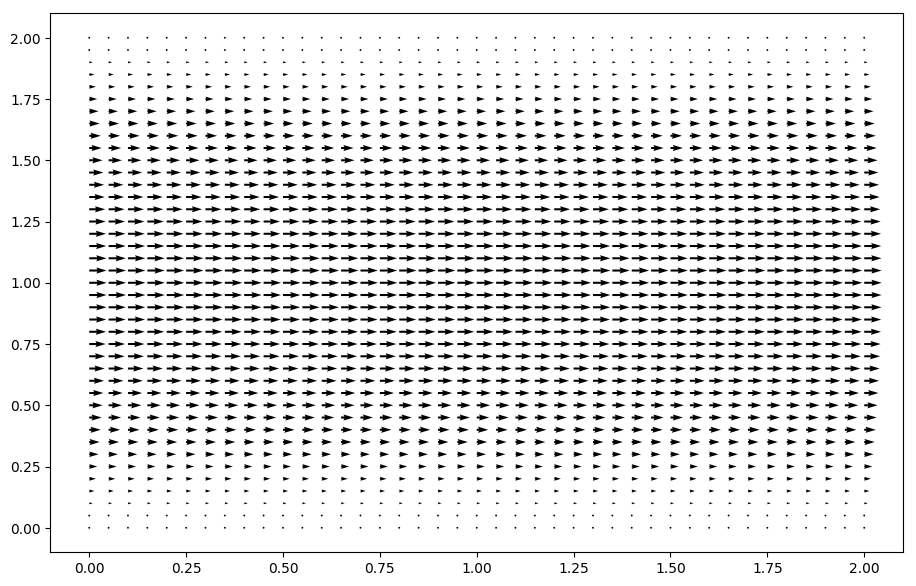

PyObject <matplotlib.quiver.Quiver object at 0x7f4af01659b0>

In [175]:
fig = plt.figure(figsize = (11,7), dpi=100)
plt.quiver(x, y, u, v)

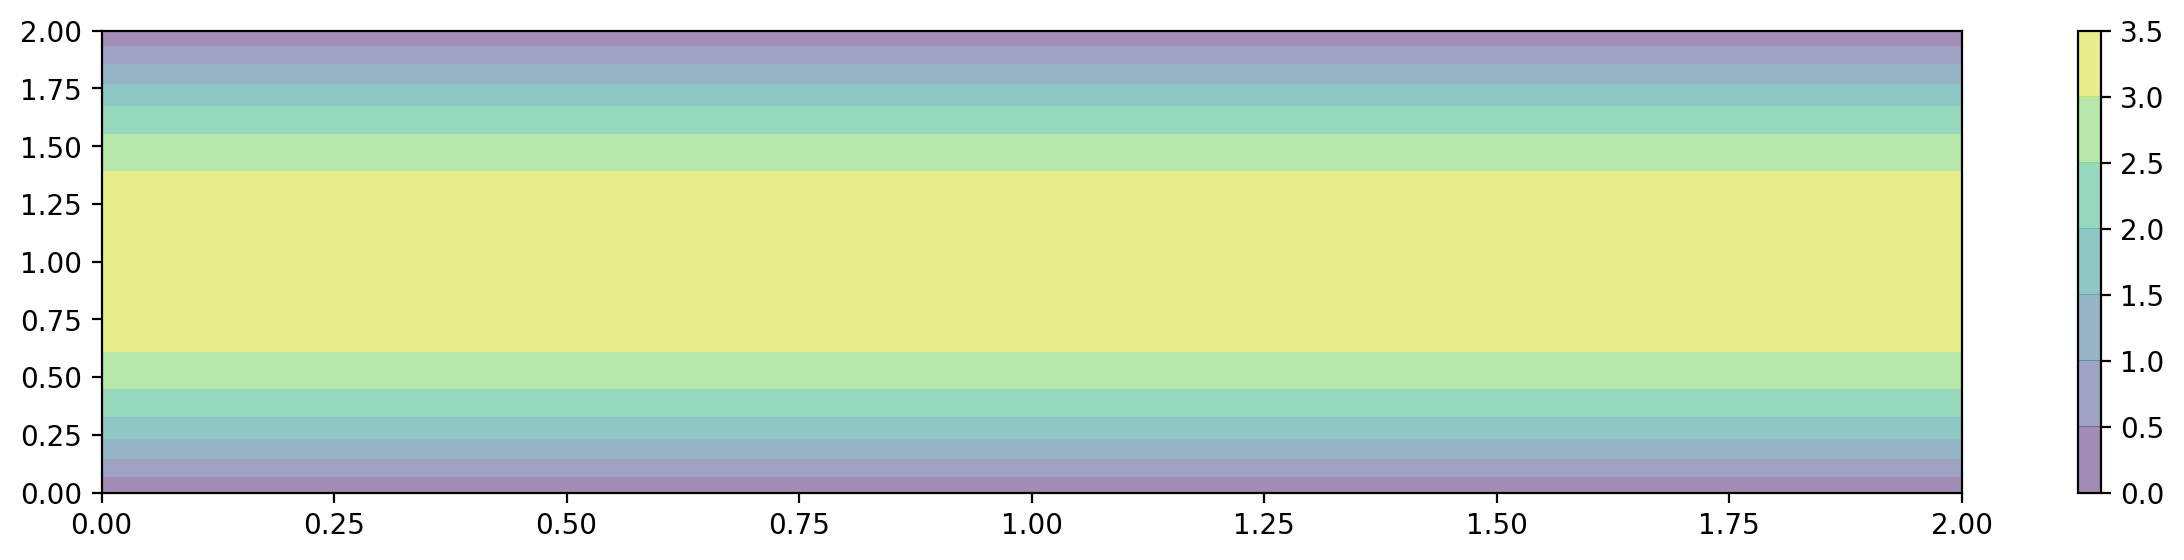

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4a9a7adba8>

In [183]:
fig = plt.figure(figsize=(15, 3), dpi=200)
plt.contourf(x, y, u, alpha=0.5, cmap=cm.viridis)
plt.colorbar()